# Guitar ETL and EDA

In [1]:
import os, io, requests, csv, sys

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from scipy.stats import boxcox
from operator import itemgetter
from datetime import datetime

In [2]:
sys.path.insert(0, 'objects')
sys.path.insert(0, 'data')
sys.path.insert(0, 'pickles')

### Here's a Class with *Lots* of Attributes (Features)

Some ducking was required to handle auctions missing certain details.

In [3]:
from Shade_Sale import Shade_Sale

### Loop Through All Item JSON Data Files, Instantiate Class Objects

In [4]:
file_names = [name for name in os.listdir('data/specs/') if not name.startswith('.')] # Ignores hidden files on mac


In [5]:
items = []
for filename in file_names:
    try:
        this_item = Shade_Sale('data/listings', 'data/specs', filename)
        if "LOT" not in this_item.title.upper() and this_item.country_seller == 'US':# and this_item.price > 110 and this_item.price < 890:
            items.append(this_item)
    except ValueError:
        print('valerror')
        pass

In [6]:
len(items) # Our sample size.

2065

********

## EDA

**********

__Price Distribution:__

In [7]:
orig_prices = pd.Series([item.price for item in items], name = 'prices')

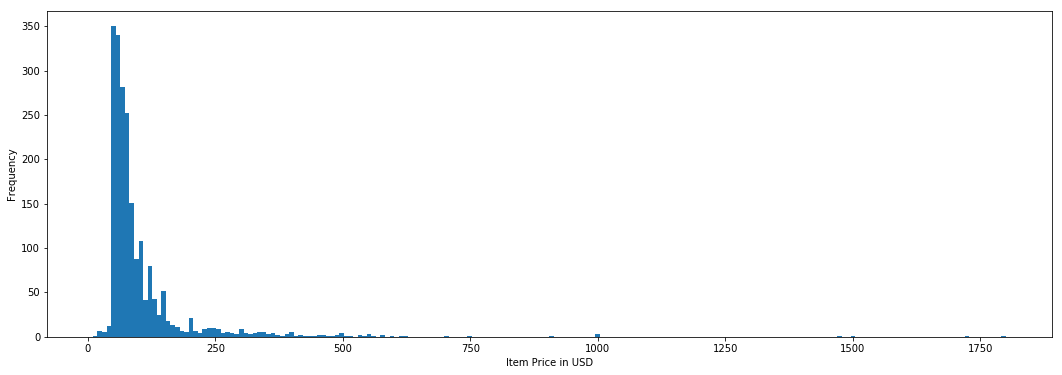

In [8]:
plt.figure(figsize = (18,6))
plt.hist(orig_prices, bins=200)
plt.ylabel('Frequency')
plt.xlabel('Item Price in USD')
plt.show()

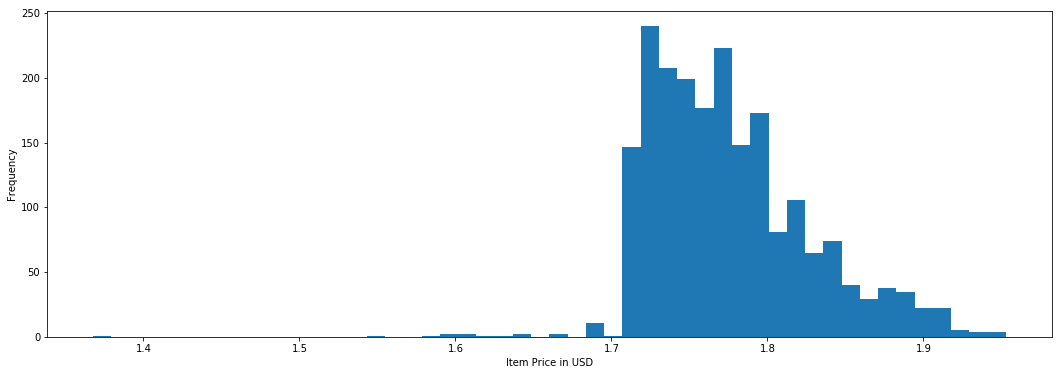

In [9]:
# prices = pd.Series([axe.price_usd for axe in axes])

BOXCOX_LAM = -.5

prices = pd.Series(boxcox([item.price for item in items], lmbda=BOXCOX_LAM), name = 'price')

plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Item Price in USD')
plt.show()

Some of the most expensive guitars:

In [10]:
spensive = [{'name':item.title,
             'price': item.price} for item in items]
sorted(spensive, key=itemgetter('price'))[-5:]

[{'name': "Oakley Romeo 1 Vintage Men's Sunglasses with additional lenses",
  'price': 1000.0},
 {'name': 'CARTIER GIVERNY GOLD & WOOD 53/22 FULL SET BROWN LENS FRANCE SUNGLASSES',
  'price': 1475.0},
 {'name': 'Oakley Mars Leather Sunglasses Fight Club Brad Pitt Tyler Durden Michael Jordan',
  'price': 1500.0},
 {'name': 'Cartier glasses\xa0', 'price': 1725.0},
 {'name': 'Oakley C Six # 379 Of 1500 Aluminum Frame Carbon Fiber Sunglasses',
  'price': 1800.0}]

**********

__Text Fields, for NLP:__

Listing Title:

In [11]:
[item.title for item in items][:20] # All listings must have a title

['Slightly Used Oakley Fuel Cell sunglasses Woodland Camo Shallow Blue Polarized',
 'RAY BAN RB8313 014/N6 Carbon Fiber Brown/Polarized Brown Sunglasses 61mm w/Case',
 'VINTAGE B&L RAY BAN BLACK PS1 PREDATOR SERIES CATS SUNGLASSES',
 'Oakley Holbrook Matt Black/Blue mirror POLARIZED ',
 'Maui Jim MJ111 Palms Tortoiseshell Sunglasses (Made In Italy)',
 'Oakley Jury OO4045-03 Sunglasses with Ice Iridium Lenses',
 'Tom Ford Black 52mm Snowdon Gradient Smoke Sunglasses FT0237-05B James Bond',
 'OAKLEY OO9135-07 JUPITER SQUARED Woodgrain TUNGSTEN IRIDIUM POLARIZED AUTHENTIC ',
 'Costa Del Mar Harpoon Polarized HR 68 Sunglasses Barely Used',
 'Cartier Sunglasses with Wood Frame and Gold Trim',
 'Oakley Eye Patch 2 Polished Black Violet Iridium 009136-06 RARE',
 'Oakley flak 2.0 xl frames',
 'Rare Jacques Marie Mage Unisex HATFIELD Matte Black/Amber Lenses',
 'Oakley Holbrook Woodgrain Frame, Prizm Daily Polarized Lens Sunglasses OO9102-B7',
 'Kaenon Titanium Rhino Sunglasses | Unisex | Polar

Mean Length of Title:

In [12]:
mean_title_len = sum(len(item.title) for item in items)/len(items)
print(f'{round(mean_title_len)} characters per title on average.')

60 characters per title on average.


In [13]:
print(f'{round(sum(1 for item in items if len(item.title) < 46) / len(items)*100,2)}% of listings have less than 46 characters in the title.')


24.26% of listings have less than 46 characters in the title.


Maybe "title has length less than 46 characters" should be a one-hot variable.

Listing __Sub__titles:

In [14]:
[item.subtitle for item in items if item.subtitle != None][-5:]
print(f'{round(((len([item.subtitle for item in items if item.subtitle != None]) / len(items))*100),2)}% of listings include a subtitle.')

1.02% of listings include a subtitle.


Condition Descriptions:

In [15]:
[item.condition_description for item in items if item.condition_description != None][-5:]
print(f'{round(((len([item.condition_description for item in items if item.condition_description != None]) / len(items))*100),2)}% of listings include a condition description.')

23.1% of listings include a condition description.


Example of Description Full Text:

In [16]:
print([item.description for item in items][20:22])
print(f'\n{round(((len([item.description for item in items if item.description != None]) / len(items))*100),2)}% of listings include a text description.')

["Pre-owned pair of Authentic Ray-Ban sunglasses. Great shape, excellent condition. The lenses and frame are pretty clean, seems that the glasses were barely worn! Except for a few scratches on the frame that should not be noticeable when glasses are on. Please see pictures for better understanding the condition of the glasses. Very stylish sunglasses made with the top quality of the brand! MSRP $213 Comes with the authentic Ray Ban case and cleaning cloth. NO RETURNS accepted unless the item is grossly misrepresented. No international shipping. The glasses will be shipped within 2 business days after the payment is received. I use USPS first class delivery service unless the other type is mutually agreed. Description MUST BE READ before placing a bid/win/purchase the item, I will not cancel the order if you haven't read the description or/and changed your mind or/and someone used your phone. Payment must be made within 2 days. Unpaid item case will be opened automatically after 48 hou

***********

__Number of Pics on eBay listing:__

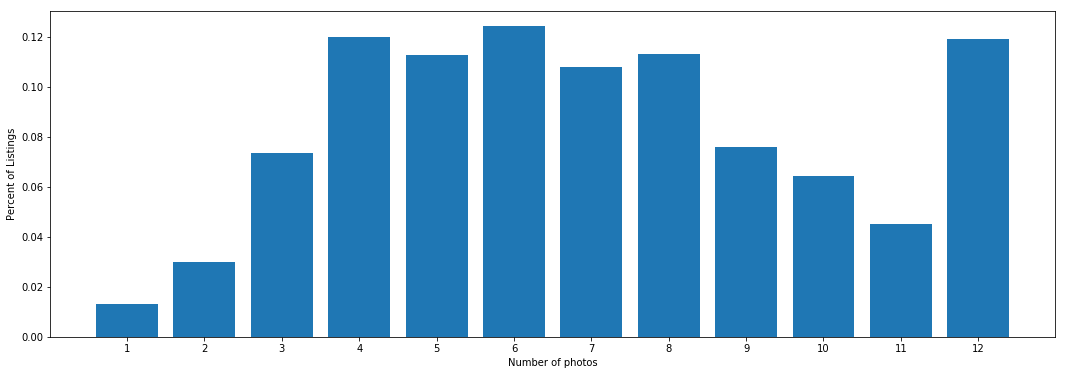

In [17]:
pic_quants = pd.Series([item.pic_quantity for item in items]).value_counts()
plt.figure(figsize = (18,6))
plt.bar(pic_quants.index, pic_quants.values/len(items))
plt.xticks(pic_quants.index)
plt.xlabel("Number of photos")
plt.ylabel("Percent of Listings")
plt.show()

In [18]:
for num_photos in range(13,0,-1):
    print(f'{round(len([item.pic_quantity for item in items if item.pic_quantity < num_photos]) / len(items) * 100, 1)}% of auctions have less than {num_photos} photos.')

100.0% of auctions have less than 13 photos.
88.1% of auctions have less than 12 photos.
83.6% of auctions have less than 11 photos.
77.1% of auctions have less than 10 photos.
69.5% of auctions have less than 9 photos.
58.2% of auctions have less than 8 photos.
47.4% of auctions have less than 7 photos.
35.0% of auctions have less than 6 photos.
23.7% of auctions have less than 5 photos.
11.7% of auctions have less than 4 photos.
4.3% of auctions have less than 3 photos.
1.3% of auctions have less than 2 photos.
0.0% of auctions have less than 1 photos.


__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [19]:
[item.pic for item in items][:5] # Just first five. You get it

['http://thumbs1.ebaystatic.com/m/mDCERgxxsE0WlZrgwo7hS3Q/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mq20ZEPFK1BnOhrqFrkC4Hw/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mO2MSKaNg7EsNxfCgIy9x-w/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mhpTfW_STjeN68okkIFZb9Q/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mkLG_KbQH61oTrL7JNvyH0w/140.jpg']

**********

**Shipping Type:**

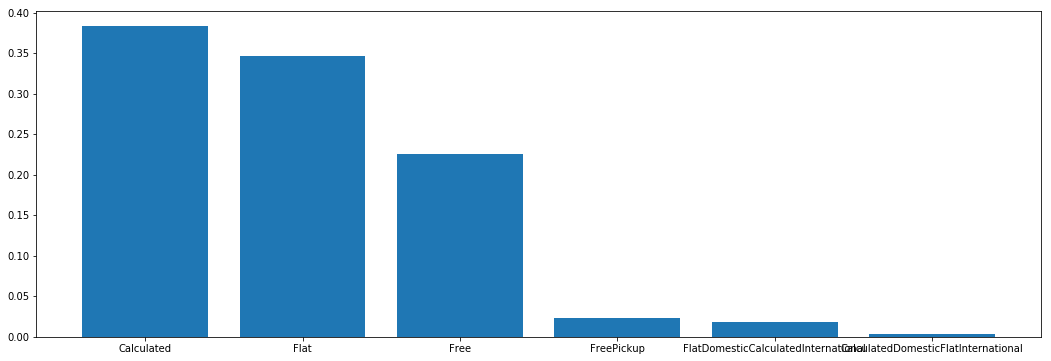

In [20]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([item.ship_type for item in items]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(items))
plt.show()

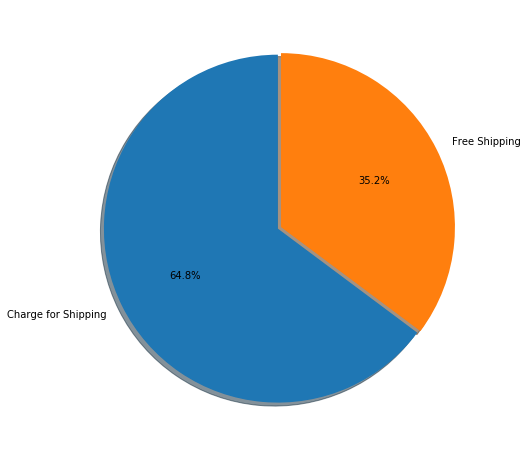

In [21]:
free = pd.Series([item.price_shipping == 0 for item in items]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(free.values, explode=[.01,.01], labels=['Charge for Shipping', 'Free Shipping'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering Expedited Shipping:**

$2.7 - Average shipping cost (including free shipping)
$7.67 - Average shipping cost (if charging for shipping)


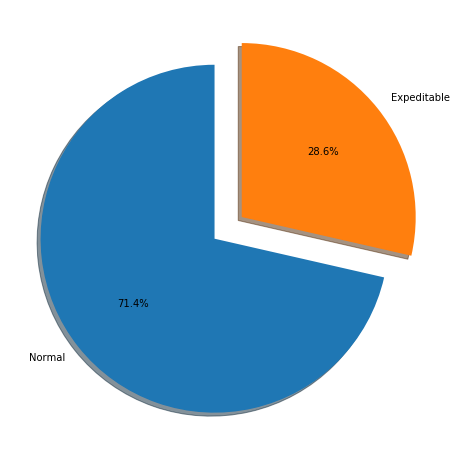

In [22]:
print(f'${round(sum(item.price_shipping for item in items) / len([item.price_shipping for item in items]),2)} - Average shipping cost (including free shipping)')
print(f'${round(sum(item.price_shipping for item in items if item.price_shipping != 0) / len([item.price_shipping for item in items if item.price_shipping]),2)} - Average shipping cost (if charging for shipping)')

exp = pd.Series([item.ship_expedite for item in items]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__Listing Types:__

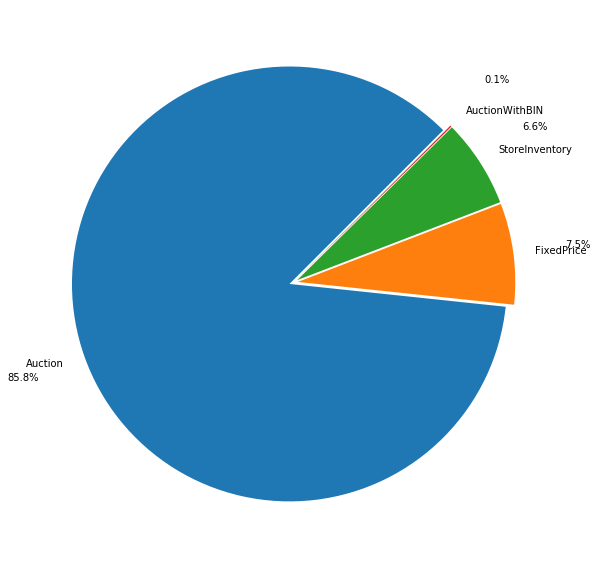

In [23]:
listing_types = pd.Series([item.listing_type for item in items if item.listing_type != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(listing_types.values, 
        labels = listing_types.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=45,
        explode = np.full(len(listing_types), .02))
plt.show()

****

__TEMPORAL STUFF__

**Handling Time in Days:**

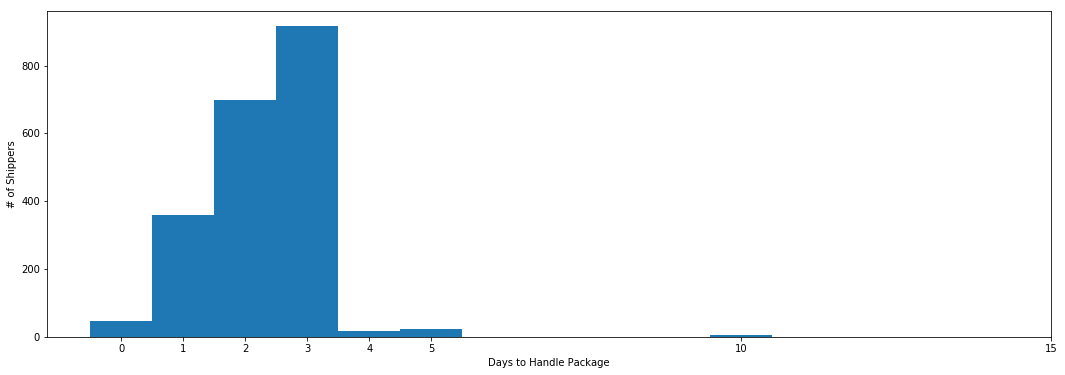

In [24]:
plt.figure(figsize = (18,6))
times = pd.Series([item.ship_handling_time for item in items if item.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))-.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

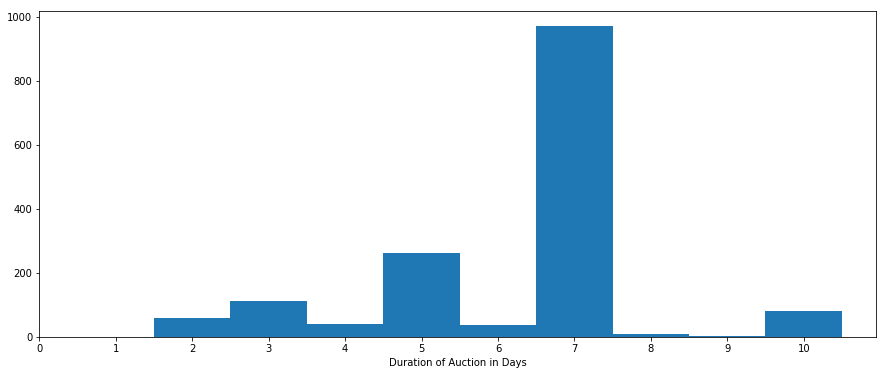

In [25]:
plt.figure(figsize = (15,6))
plt.hist([item.duration/24 for item in items], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Duration of Auction in Days')
plt.show()

**Weekday of Auction Start:**

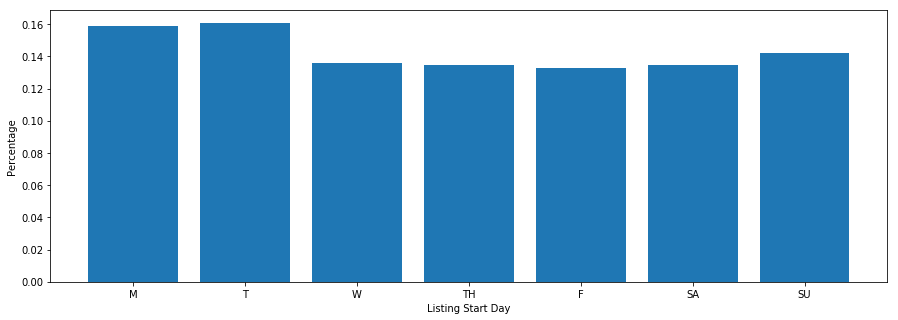

In [26]:
days = pd.Series([item.start_weekday for item in items]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(items))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

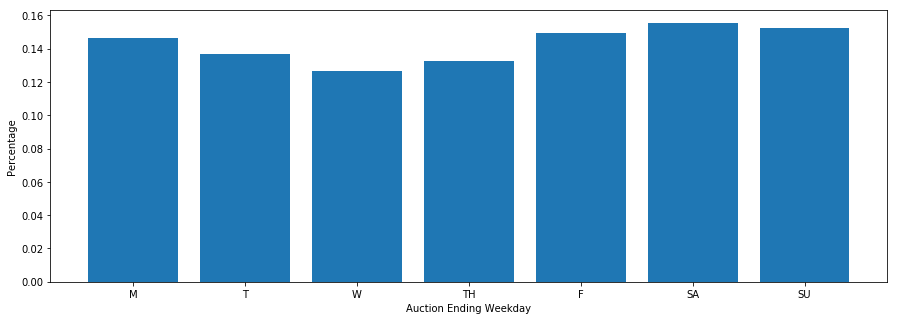

In [27]:
days = pd.Series([item.end_weekday for item in items]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(items))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

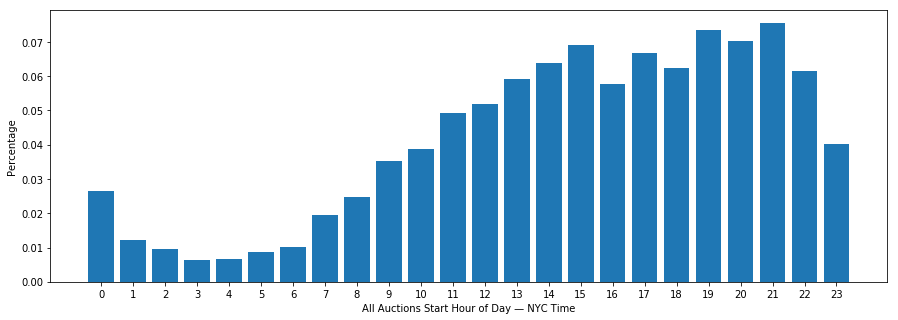

In [28]:
start_hours = pd.Series([item.start_time.hour for item in items]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((start_hours.index-5+24)%24, start_hours.values/len(items))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions Start Hour of Day — NYC Time")
plt.show()

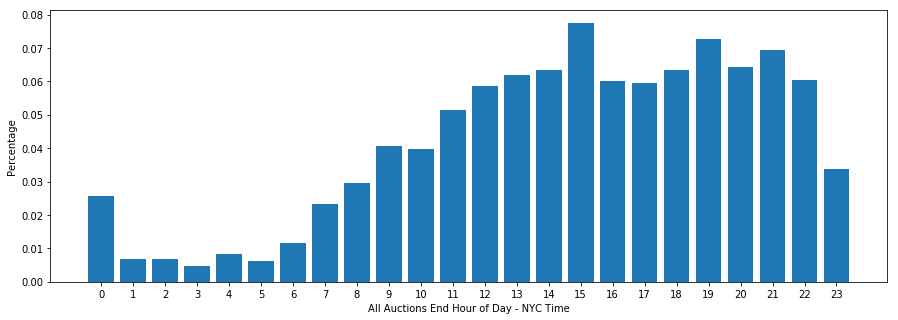

In [29]:
end_hours = pd.Series([item.end_time.hour for item in items]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((end_hours.index - 5 + 24)%24, end_hours.values/len(items))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions End Hour of Day - NYC Time")
plt.show()

**Percentage of Auctions Offering Returns:**

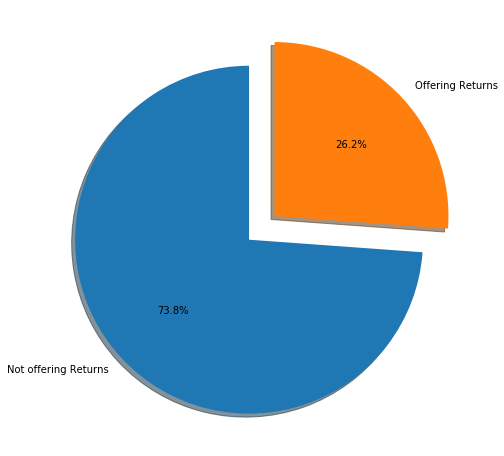

In [30]:
returns = pd.Series([item.returns for item in items]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(returns.values, explode=[.1,.1], labels=['Not offering Returns', 'Offering Returns'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Return Time Window** (of those offering returns):

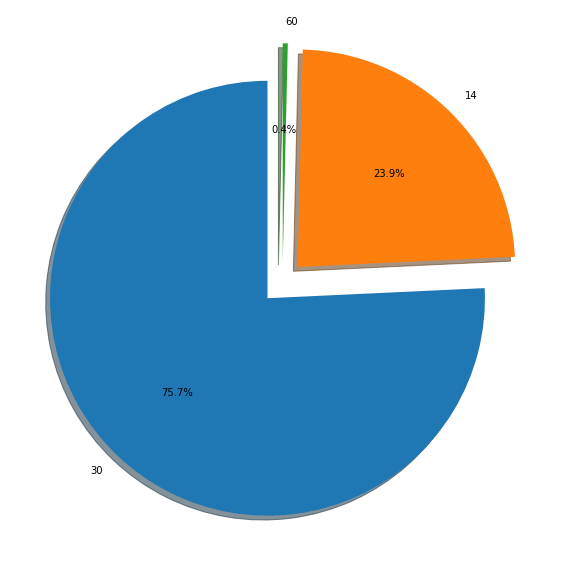

In [31]:
returns = pd.Series([item.returns_time for item in items if item.returns_time > 0]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index, 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering AutoPay:**

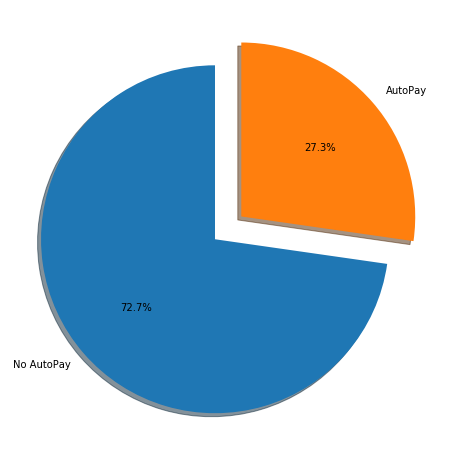

In [32]:
auto = pd.Series([item.autopay for item in items]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(auto.values, explode=[.1,.1], 
        labels=['No AutoPay', 'AutoPay'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__"Best Offer":__

In [33]:
print(f'{round((sum(item.best_offer_enabled for item in items) / len(items)*100),2)}% of listings have "Best Offer" enabled. (Potential buyers are allowed to negotiate price)')


37.38% of listings have "Best Offer" enabled. (Potential buyers are allowed to negotiate price)


***

**Countries of Sellers:**

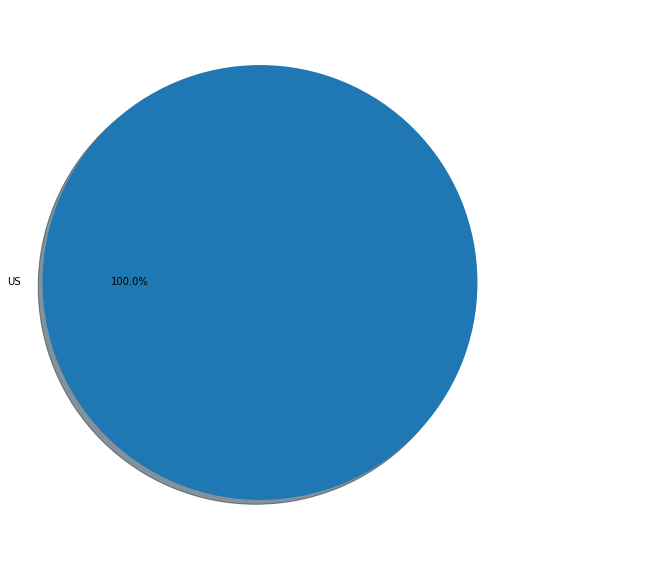

In [34]:
plt.figure(figsize = (10,10))
countries = pd.Series([item.country_seller for item in items]).value_counts()
plt.pie(countries.values, labels=countries.index, 
                            explode = np.full(len(countries), .5), 
        autopct='%1.1f%%',
       shadow = True)
plt.show()

__Seller Karma:__

Ebay Seller Feedback Score:

/Users/rob/.local/share/virtualenvs/ebay_valuator-emtoraMG/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rob/.local/share/virtualenvs/ebay_valuator-emtoraMG/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


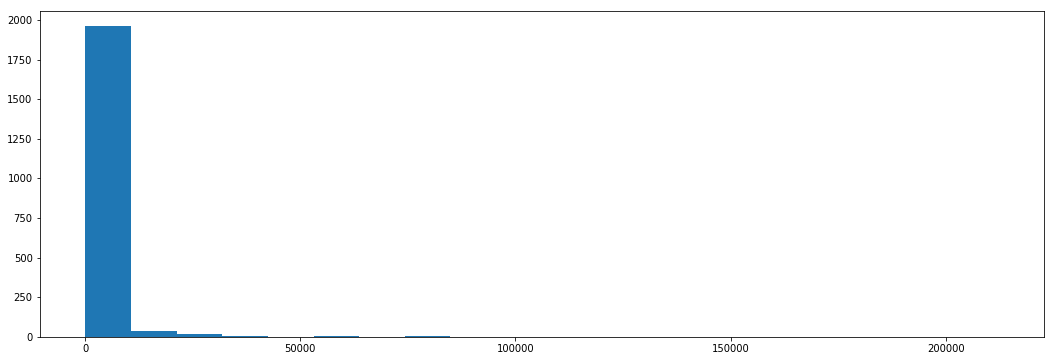

In [35]:
scores = pd.Series([item.seller_feedback_score for item in items])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

In [36]:
scores.min(), scores.max()

(-2.0, 212249.0)

eBay Positive Feedback Percentage:

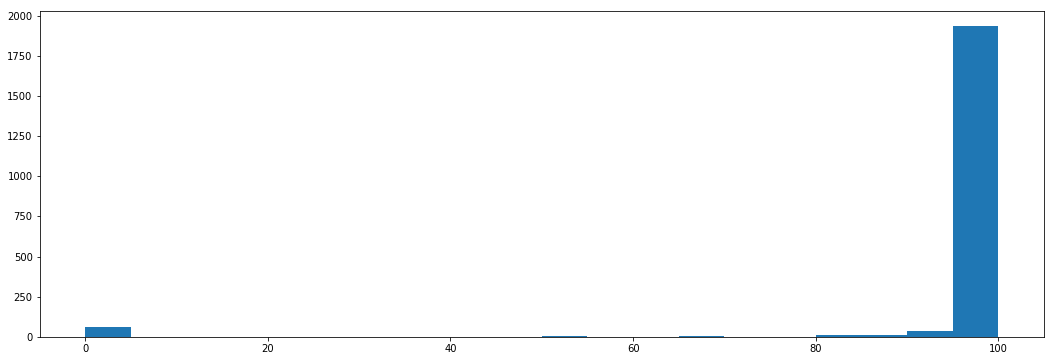

In [37]:
scores = pd.Series([item.seller_positive_percent for item in items])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

***

## ITEM DETAILS

__Countries of Manufacture:__

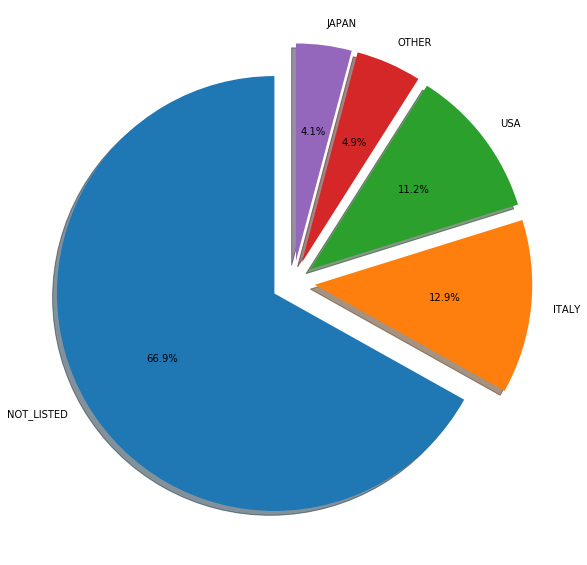

In [38]:
plt.figure(figsize = (10,10))
countries = pd.Series([item.country_manufacture for item in items]).value_counts()
plt.pie(countries.values, labels= countries.index, explode = np.full(len(countries), .1), 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [39]:
per = round(sum(pd.Series(len([axe.country_manufacture for axe in items if axe.country_manufacture != "UNKNOWN"]) / len(items))*100),2)
print(f'{per}% of auctions list a country of manufacture where they\'re supposed to.')

100.0% of auctions list a country of manufacture where they're supposed to.


In [40]:
items[10]._Shade_Sale__body

{'listing': {'itemId': ['192862479099'],
  'title': ['Oakley Eye Patch 2 Polished Black Violet Iridium 009136-06 RARE'],
  'globalId': ['EBAY-US'],
  'primaryCategory': [{'categoryId': ['79720'],
    'categoryName': ['Sunglasses']}],
  'galleryURL': ['http://thumbs4.ebaystatic.com/m/mf1pg4m4EoQT2zC6OX0pbgw/140.jpg'],
  'viewItemURL': ['http://www.ebay.com/itm/Oakley-Eye-Patch-2-Polished-Black-Violet-Iridium-009136-06-RARE-/192862479099'],
  'paymentMethod': ['PayPal'],
  'autoPay': ['true'],
  'postalCode': ['23601'],
  'location': ['Newport News,VA,USA'],
  'country': ['US'],
  'shippingInfo': [{'shippingServiceCost': [{'@currencyId': 'USD',
      '__value__': '0.0'}],
    'shippingType': ['FreePickup'],
    'shipToLocations': ['Worldwide'],
    'expeditedShipping': ['true'],
    'oneDayShippingAvailable': ['false'],
    'handlingTime': ['1']}],
  'sellingStatus': [{'currentPrice': [{'@currencyId': 'USD',
      '__value__': '75.0'}],
    'convertedCurrentPrice': [{'@currencyId': 'USD'

__US Seller Locations, by Zip Code:__

In [41]:
sales = [(items.zip[0], items.start_time) for items in items if items.country_seller == 'US' and items.zip != None]

In [42]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [43]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [44]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [45]:
def write_kepler_csv():
    with open('../_for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{round((omissions/len(sales))*100, 2)}% of zips were not found")

In [46]:
write_kepler_csv()

1.58% of zips were not found


***

**Properties:**

* Temple length (?)
* Country of mfctr
* Modified Item (?)
* Frame material
* Frame color
* Lens Color
* Lens technology
* Brand
* Model (too many)
* Style
* Protection

__Brands__

In [47]:
brand_counts = pd.Series([item.brand for item in items]).value_counts()

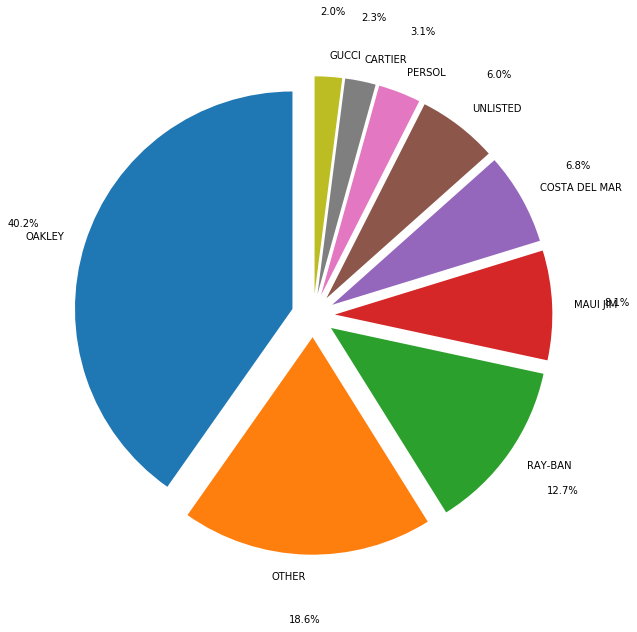

In [48]:
plt.figure(figsize = (10,10))
plt.pie(brand_counts.values, 
        labels = brand_counts.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=90,
        explode = np.full(len(brand_counts), .1))
plt.show()